In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import urllib.request
import time

# 基学习器

采用C4.5决策树作为基学习器。

## 信息增益比

随机变量$X$的熵定义为
$$
H(X)=-\sum_{i=1}^{n} p_{i} \log p_{i}
$$

随机变量$X$给定的条件下随机变量$Y$的条件熵定义为
$$
H(Y|X)=\sum_{i=1}^{n}H(Y|X=x_{i})P(X=x_i)
$$



In [2]:
# 计算熵
def calEntroy(X):
    cnt = Counter(X)
    size = len(X)
    ent = 0
    for key, val in cnt.items():
        p = val/size
        ent += -p*np.log2(p) # 计算2为底的对数
    return ent

当熵和条件熵中的概率由数据估计(特别是极大似然估计)得到时，所对应的熵与条件熵分别称为经验熵（empirical entropy) 和经验条件精（empirical conditional entropy) 。
特征$A$对训练数据集$D$的信息增益定义为
$$
g(D, A)=H(D)-H(D|A)
$$



In [3]:
# 计算信息增益
def calInfoGain(X,Y):
    size = len(Y)
    H_D = calEntroy(Y) # 计算数据集的经验熵
    cnt = Counter(X) # 特征的分类统计
    H_DA = 0
    for key, val in cnt.items():
        D_i = Y[X==key] # 选出X=key的Y
        H_DA += val/size*calEntroy(D_i)
    return H_D - H_DA

特征$A$对$D$的划分为$\{D_1,D_2,…,D_n\}$，$\sum_{i=1}^n|D_i|=|D|$。
特征$A$对训练数据集$D$的分裂信息定义为
$$
H_{A}(D)=-\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} \log _{2} \frac{\left|D_{i}\right|}{|D|}
$$

特征$A$对训练数据集$D$的信息增益比定义为
$$
g_{R}(D, A)=\frac{g(D, A)}{H_{A}(D)}
$$

In [4]:
# 计算信息增益比
def calInfoGainRatio(X,Y):
    split_info = calEntroy(X) # 计算分裂信息
    info_gain = calInfoGain(X,Y) # 计算信息增益
    return info_gain/split_info

## C4.5的生成算法

输入:训练数据$D$，特征集A阈值$\epsilon$

输出:决策树$T$

(1) 如果$D$中所有实例属于同一类$C_k$，则置$T$为单结点树，并将$C_k$作为该结点的类，返回$T$；

(2) 如果$A=\varnothing$，则置$T$为单结点树，并将$D$中实例数最大的类$C_k$作为该结点的类，返回$T$；

(3) 否则，计算$A$中各特征对$D$的信息增益比，选择信息增益比最大的特征$A_g$；

(4) 如果$A_g$的信息增益比小于阔值$\epsilon$，则置$T$为单结点树，并将$D$中实例数最大的类$C_k$作为该结点的类，返回$T$；

(5) 否则，对$A_g$的每一可能值$\alpha_i$，依$A_g=\alpha_i$将$D$分割为子集若干非空$D_i$，将$D_i$中实例数最大的类作为标记，构建子结点，由结点及其子结点构成树$T$，返回$T$；

(6) 对结点$i$，以$D_i$为训练集，以$A-\{A_g\}$为特征集，递归地调用步(1)~步(5)，得到子树$T_i$，返回$T_i$。

In [5]:
# 决策树节点类
class TreeNode:
    def __init__(self, feather=None, alpha=None, category=None, sample=None, children=set()):
        self.feather = feather # 特征名
        self.alpha = alpha # 特征取值
        self.category = category # 分类
        self.sample = sample # 样本点
        self.children = children # 子节点

In [6]:
# 决策树基类
class DecisionTree:
    def __init__(self):
        self.root = TreeNode('F1', 'A1', 'C1',{TreeNode('F2', 'A2', 'C2'), TreeNode('F2', 'A3', 'C3')})

    # 展示决策树
    def display(self):
        def displayTree(node, depth):
            if node == None:
                return
            print('|'+(depth)*"   |"+'-'+str(depth)+'- '+str(node.feather)+' = '+str(node.alpha))
            print('|'+(depth+1)*"   |"+'==> '+'count: '+str(dict(Counter(node.sample)))+' ==> class: '+str(node.category))
            for child in node.children:
                displayTree(child, depth+1)

        print('Depth:',self.depth(), 'Leaves:',self.leaves())
        print('<BEGIN_OF_DESISION_TREE>')
        displayTree(self.root, 0)
        print('<END_OF_DESISION_TREE>')

    # 深度
    def depth(self):
        def depthTree(node):
            if not node:
                return 0
            elif not node.children:
                return 1
            else:
                depth_list = [depthTree(c) for c in node.children]
                return 1 + max(depth_list)
        return depthTree(self.root) - 1

    # 叶子节点数
    def leaves(self):
        def leavesTree(node):
            if not node:
                return 0
            elif not node.children:
                return 1
            else:
                leaves_list = [leavesTree(c) for c in node.children]
                return sum(leaves_list)
        return leavesTree(self.root)
        

In [7]:
# C4.5
class C45DecisionTree(DecisionTree):
    def __init__(self, threshold=0):
        super().__init__()
        self.threshold = threshold

    # 训练模型
    def fit(self, data, label, sample=False):
        def fitTree(data, label):
            feath_list = data.columns # 特征名称
            cnt_label = Counter(label)
            # 1. 类别完全相同，直接返回
            if len(cnt_label) == 1:
                return set()
            # 2. 无特征，直接返回
            if len(feath_list) == 0:
                return set()
            # 3. 选择最优特征
            igr, best_feath = selBestFeather(data, label)
            # 4. 比较阈值
            if igr < self.threshold:
                return set()
            # 5. 递归构造
            children = set()
            cnt_feath = Counter(data[best_feath])
            for key, val in cnt_feath.items():
                new_data = data[data[best_feath]==key].drop(columns=best_feath)
                new_label = label[data[best_feath]==key]
                cnt_new_label = Counter(new_label)
                child_node = TreeNode(best_feath, key, cnt_new_label.most_common(1)[0][0], new_label)
                child_node.children = fitTree(new_data, new_label)
                children.add(child_node)
            return children

        # 选择最优特征
        def selBestFeather(data, label):
            feath_list = data.columns # 特征名称
            '''随机采样'''
            if sample:
                k_feather = max(int(np.log2(len(feath_list))), 1)
                feath_list = np.random.choice(list(feath_list), size=k_feather, replace=False) # 随机采样
            ''''''
            max_igr = -1
            best_i = 0
            for i in range(len(feath_list)):
                igr = calInfoGainRatio(data[feath_list[i]],label)
                if igr > max_igr:
                    max_igr = igr
                    best_i = i
            return max_igr, feath_list[best_i]

        cnt_label = Counter(label)
        self.root = TreeNode(category=cnt_label.most_common(1)[0][0], sample=label)
        self.root.children = fitTree(data, label)
        return self.root

    # 预测
    def predict(self, data):
        def predictTree(node, row):
            if not node.children:
                return node.category
            else:
                for child in node.children:
                    if list(row[child.feather])[0] == child.alpha:
                        return predictTree(child, row)
                return node.category

        pred = []
        for i in range(len(data)):
            pred.append(predictTree(self.root, data[i:i+1]))
        return pred

    # 评价准确率
    def evaluate(self, data, label):
        pred = self.predict(data)
        num_true = 0
        for p, l in zip(pred, label):
            if p == l:
                num_true += 1
        return num_true/len(label)

In [8]:
# Toy Example
df=pd.read_excel('example.xlsx').drop(columns=['ID'])
data=df[df.columns[:-1]]
label=df[df.columns[-1]]
# 建立决策树
toy_example = C45DecisionTree(0.076)
toy_example.fit(data, label)
toy_example.display()

Depth: 2 Leaves: 3
<BEGIN_OF_DESISION_TREE>
|-0- None = None
|   |==> count: {'否': 6, '是': 9} ==> class: 是
|   |-1- 有自己的房子 = 是
|   |   |==> count: {'是': 6} ==> class: 是
|   |-1- 有自己的房子 = 否
|   |   |==> count: {'否': 6, '是': 3} ==> class: 否
|   |   |-2- 有工作 = 否
|   |   |   |==> count: {'否': 6} ==> class: 否
|   |   |-2- 有工作 = 是
|   |   |   |==> count: {'是': 3} ==> class: 是
<END_OF_DESISION_TREE>


# 随机森林

输入：训练样本集$D=\{(x_i,y_i)\}_{i=1}^N$，$x_i\in \mathcal{X} $，$y_i \in \mathcal{Y} $，$i=1,2,\cdots,N$，基分类器个数$T$

输出：集成分类器$f(x)$

(1) 对$ t=1,2,\cdots,T$

- 从$D$利用自助采样法随机抽取$N$个样本得到$D_t$

- 从$D_t$依决策树算法学得基分类器$f_t(x)$
    
- 决策树算法在选择划分特征时先从当前结点对应的所有特征（不妨设共$d$有个特征）中随机选择$k$个特征作为候选划分特征，再从这$k$个特征中选择最优划分特征
      
(2) 返回集成分类器
  $$
  f(x)=\mathop{\arg\min}_{y \in \mathcal{Y}} \sum^T_{t=1}I(f_t(x)=y)
  $$

In [9]:
# random forest
class RandomForest:
    def __init__(self, n_estimators, sample=True):
        self.n_estimators = n_estimators
        self.sample = sample
        self.forest = []

    # 训练模型
    def fit(self, data, label):
        df = data.join(label)
        for i in range(self.n_estimators):
            sampled = df.sample(frac=1, replace=True)
            data=sampled[sampled.columns[:-1]]
            label=sampled[sampled.columns[-1]]
            decision_tree = C45DecisionTree(0)
            decision_tree.fit(data, label, self.sample)
            self.forest.append(decision_tree)
            
    # 预测
    def predict(self, data):
        pred = []
        for i in range(len(data)):
            predTree = []
            for tree in self.forest:
                predTree.append(tree.predict(data[i:i+1])[0])
            pred.append(Counter(predTree).most_common(1)[0][0])
        return pred

    # 评价准确率
    def evaluate(self, data, label):
        pred = self.predict(data)
        num_true = 0
        for p, l in zip(pred, label):
            if p == l:
                num_true += 1
        return num_true/len(label)

# Bagging

输入：训练样本集$D=\{(x_i,y_i)\}_{i=1}^N$，$x_i\in \mathcal{X} $，$y_i \in \mathcal{Y} $，$i=1,2,\cdots,N$，基分类器个数$T$

输出：集成分类器$f(x)$

(1) 对$ t=1,2,\cdots,T$

- 从$D$利用自助采样法随机抽取$N$个样本得到$D_t$

- 从$D_t$依决策树算法学得基分类器$f_t(x)$
          
(2) 返回集成分类器
  $$
  f(x)=\mathop{\arg\min}_{y \in \mathcal{Y}} \sum^T_{t=1}I(f_t(x)=y)
  $$

In [10]:
# bagging
class Bagging(RandomForest):
    def __init__(self, n_estimators):
        super().__init__(n_estimators, False)

# 算法对比

从UCI上选择chess和tic-tac-toe数据集，均为离散特征的分类问题。

In [11]:
# 读取UCI数据
def loadDataset(fname, label_first=True, is_plot=False):
    url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/'+fname
    raw_data = urllib.request.urlopen(url)
    df = pd.read_csv(raw_data, header=None)
    df = df.replace('?', np.nan)
    df = df.dropna(axis=0, how='any')
    df = df.reset_index(drop=True)
    if label_first:
        data = df[df.columns[1:]]
        label = df[df.columns[0]]
    else:
        data = df[df.columns[0:-1]]
        label = df[df.columns[-1]]

    if is_plot:
        plt.hist(label)
        plt.title(fname)
    return data, label

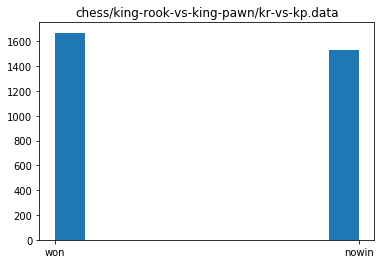

In [12]:
data, label = loadDataset('chess/king-rook-vs-king-pawn/kr-vs-kp.data', False, is_plot=True)

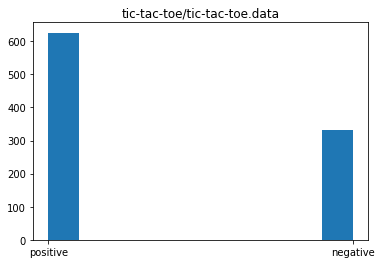

In [13]:
data, label = loadDataset('tic-tac-toe/tic-tac-toe.data', False, is_plot=True)

将数据集按照3:1划分为训练集和测试集，分别使用随机森林和Bagging在不同的基学习器个数下进行训练和预测，比较测试集准确率和训练时间。

In [14]:
# 对阈值遍历
def comparison(fname, label_first=True, lb=1, ub=100, step=1):
    data, label = loadDataset(fname, label_first)
    data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=0.25, random_state=2020, stratify=label)
    comp = {'RF_acc':[], 'BG_acc':[], 'RF_dur':[], 'BG_dur':[]}
    for T in np.arange(lb, ub, step):
        random_forest = RandomForest(T)
        t_start = time.time()
        random_forest.fit(data_train, label_train)
        t_end = time.time()
        comp['RF_acc'].append(random_forest.evaluate(data_test, label_test))
        comp['RF_dur'].append(t_end - t_start)

        bagging = Bagging(T)
        t_start = time.time()
        bagging.fit(data_train, label_train)
        t_end = time.time()
        comp['BG_acc'].append(bagging.evaluate(data_test, label_test))
        comp['BG_dur'].append(t_end - t_start)

    # acc
    plt.plot(np.arange(lb, ub, step),comp['RF_acc'])
    plt.plot(np.arange(lb, ub, step),comp['BG_acc'])
    plt.legend(['RandomForest', 'Bagging'])
    plt.title('accuracy')
    plt.xlabel('n_estimators')
    plt.ylabel('test_acc/%')
    plt.show()

    # dur
    plt.plot(np.arange(lb, ub, step),comp['RF_dur'])
    plt.plot(np.arange(lb, ub, step),comp['BG_dur'])
    plt.legend(['RandomForest', 'Bagging'])
    plt.title('duration')
    plt.xlabel('n_estimators')
    plt.ylabel('time/s')
    plt.show()

    return comp

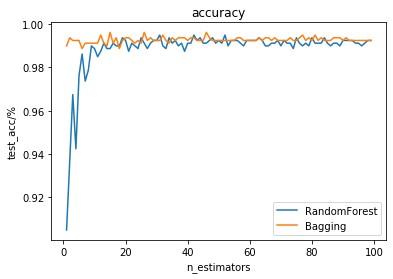

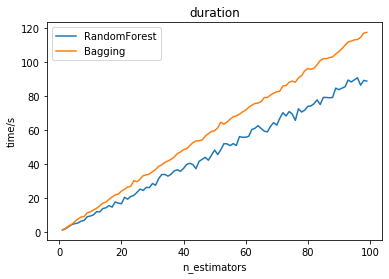

In [15]:
comp1 = comparison('chess/king-rook-vs-king-pawn/kr-vs-kp.data', False)

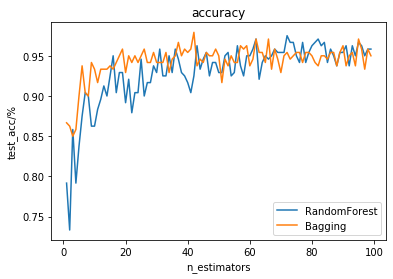

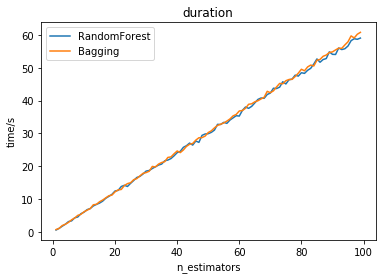

In [16]:
comp2 = comparison('tic-tac-toe/tic-tac-toe.data', False)